# Plotting the delivery areas
Using Geopandas 
Using shape file from: https://public.opendatasoft.com/explore/dataset/georef-netherlands-postcode-pc4/table/?refine.prov_name=Groningen&refine.gem_name=Groningen&location=10,53.21082,6.61855&basemap=jawg.light 

In [2]:
import pandas as pd
import geopandas as geopandas
import matplotlib.pyplot as plt
import numpy
import folium
from shapely.geometry import Point

In [4]:
shp_zip_codes = geopandas.read_file("GEO-data/georef-netherlands-postcode-pc4.shp")[["pc4_code", "geometry"]]
#rename column
shp_zip_codes.columns = ["Postcode", "geometry"]
df_dabba = pd.read_excel("Dabba.xlsx", names = ["Klanteigenaar", "Aantal", "Adres", "Postcode", "Datum bezorgd"], usecols="B,F,G,H,O") 
print(df_dabba.info())
# change the 6 postal code to the first 4 numberecal codes
df_dabba["Postcode"] = df_dabba["Postcode"].apply(lambda x:x[:4])

# count the amount of unqiue postalcodes
df_dabba['Deliveries'] = df_dabba['Postcode'].map(df_dabba['Postcode'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19814 entries, 0 to 19813
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Klanteigenaar  19814 non-null  object        
 1   Aantal         19814 non-null  float64       
 2   Adres          19814 non-null  object        
 3   Postcode       19814 non-null  object        
 4   Datum bezorgd  19814 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 774.1+ KB
None


In [3]:
# Filter all the postalcodes in the geoframe based on the postalcodes in the dabba dataframe
shp_zip_codes_sorted_dabba = shp_zip_codes[shp_zip_codes["Postcode"].isin(df_dabba["Postcode"].unique())]
# create area in km2 column
shp_zip_codes_sorted_dabba["Area (km2)"] = shp_zip_codes_sorted_dabba['geometry'].to_crs({'init': 'epsg:23095'}).map(lambda p: p.area / 10**6)

c:\Users\tobia\miniconda3\envs\lastmile\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\tobia\miniconda3\envs\lastmile\lib\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [4]:
# merge dabba dataframe with the geoframe
merge = pd.merge(df_dabba[["Datum bezorgd", "Postcode", "Deliveries"]], shp_zip_codes_sorted_dabba, on="Postcode").drop_duplicates()

# #get the number of operational workdays 
working_days = len(merge["Datum bezorgd"].unique())
# calculate the route length approximation per entry
k = 0.92
n = merge["Deliveries"] / working_days # take the total of all deliveries within and postalcode area and devided it by the amount of workingdays
A = merge["Area (km2)"]

# Calculate and add Beardwood as new column in km
merge["Beardwood approx"] = k * numpy.sqrt((n * A))
# merge[["Postcode", "Area (km2)", "Deliveries", "Beardwood approx"]].sort_values(by="Postcode").to_excel(
#     "Postcode_area_deliveries.xlsx", header=["Postcode gebied (p)", "A", "N", "Beardwood zonder depots"]
#     )

# Results 
Now we have an dataframe including the Beardwood approximation per postalcode based on Dabba information system. We can plot the following maps.
1. general results map based on Postalcode
2. specific on map based on Beardwood's approximation without the D variable

In [5]:
# create a new geoframe based on the merge
results = geopandas.GeoDataFrame(merge[["Postcode", "Deliveries", "Area (km2)", "Beardwood approx"]], geometry=merge["geometry"])
# A CRS tells Python how those coordinates relate to places on the Earth
results.set_crs(epsg=4326, inplace=True)

,Postcode,Deliveries,Area (km2),Beardwood approx,geometry
0,9726,481,0.601153,2.258043,"POLYGON ((6.55042 53.21567, 6.55138 53.21556, ..."
3,9726,481,0.601153,2.258043,"POLYGON ((6.55042 53.21567, 6.55138 53.21556, ..."
4,9726,481,0.601153,2.258043,"POLYGON ((6.55042 53.21567, 6.55138 53.21556, ..."
15,9726,481,0.601153,2.258043,"POLYGON ((6.55042 53.21567, 6.55138 53.21556, ..."
22,9726,481,0.601153,2.258043,"POLYGON ((6.55042 53.21567, 6.55138 53.21556, ..."
...,...,...,...,...,...
19804,9747,40,2.646747,1.366323,"MULTIPOLYGON (((6.53141 53.23458, 6.53134 53.2..."
19805,9747,40,2.646747,1.366323,"MULTIPOLYGON (((6.53141 53.23458, 6.53134 53.2..."
19808,9747,40,2.646747,1.366323,"MULTIPOLYGON (((6.53141 53.23458, 6.53134 53.2..."
19809,9747,40,2.646747,1.366323,"MULTIPOLYGON (((6.53141 53.23458, 6.53134 53.2..."


In [ ]:
results.explore(
    column="Postcode",
    tooltip=['Postcode', 'Area (km2)', 'Deliveries', "Beardwood approx"],
    popup=True,
    tiles="CartoDB positron", 
    cmap="Set1", 
    name="Amount of deliveries in Groningen per postalcode area"
) 

In [ ]:
results.explore(
    column="Beardwood approx",
    tooltip=['Postcode', 'Area (km2)', 'Deliveries', "Beardwood approx"],
    popup=True,
    tiles="CartoDB positron", 
    cmap="OrRd", 
    name="Beardwood approximation per postalcode area"
) 

# Influence of the depot location 
Now we have plotted the data and calculated the Beardwood approximation for each postalcode area, we want to add an other factor: depot location. Let start by adding an location marker on the current latitude and longitude position of Cycloon called depot 0.

In [6]:
lat_long_groningen = [53.21917, 6.56667] # starting location of the folium map
depots_locations = [Point(6.598278, 53.210898), Point(6.528022935211814, 53.22563730386978), Point(6.574485373877002, 53.246475527023634), Point(6.555842080055761, 53.201872050167395)]

## Calculate D
Now we want to calculate the distance between the marker on the map and the different postal code areas called D. As D is the distance, we want to multiply it by 2 because you cycle from the depot to the delivery area and back. 

In [7]:
i = 0
for depot_location in depots_locations:
    distances = []
    for phane in results.geometry:
        geo_phane = geopandas.GeoSeries(phane)
        geo_phane.set_crs(23095, inplace=True)
        geo_point = geopandas.GeoSeries(depot_location)
        geo_point.set_crs(23095, inplace=True) 
        d = geo_phane.distance(geo_point).values[0] * 100
        distances.append(d)
    distances = numpy.array(distances) # calculate D
    # results["D_depot_{0}".format(i)] = distances
    results["T*_depot_{0}".format(i)] = (2*distances) + results["Beardwood approx"]
    i=i+1

## Calculate the influence of T* based the results with D locations 
Take the min between the T* columns and sum them.  

In [8]:
results["2_depots"] = results[["T*_depot_0", "T*_depot_1"]].min(axis=1)
results["3_depots"] = results[["T*_depot_0", "T*_depot_1", "T*_depot_2"]].min(axis=1)
results["4_depots"] = results[["T*_depot_0", "T*_depot_1", "T*_depot_2", "T*_depot_3"]].min(axis=1)

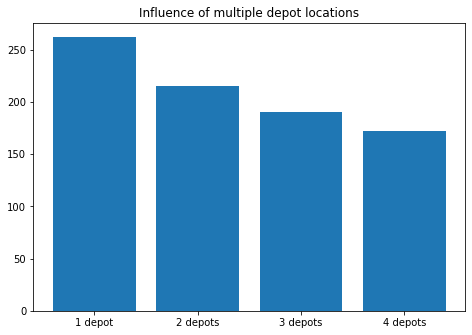

In [9]:
depot_1 = sum(results["T*_depot_0"]) / working_days
depot_2 = sum(results["2_depots"]) / working_days 
depot_3 = sum(results["3_depots"]) / working_days
depot_4 = sum(results["4_depots"]) / working_days
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
depots = ["1 depot", "2 depots", "3 depots", "4 depots"]
sum_route_length_per_depot = [depot_1, depot_2, depot_3, depot_4]
ax.bar(depots,sum_route_length_per_depot)

plt.title("Influence of multiple depot locations")
plt.show()

# results[[]].plot(kind="bar", figsize=(16, 20), width=0.85) 


## Compare new situation with the current (old) situation in precentage (%)
Compare the old situation of 1 depot with the new situation of multiple depots (2, 3, and 4) by using the following formula:
(new - old) / old * 100 

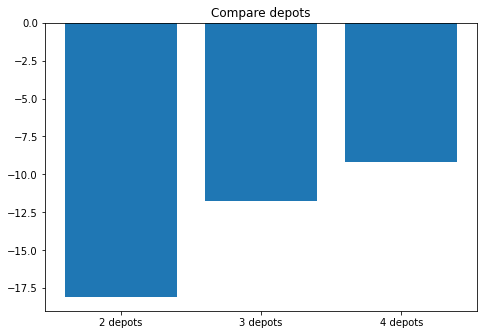

In [11]:
depot_1_to_2 = ((depot_2 - depot_1) / depot_1) * 100
depot_2_to_3 = ((depot_3 - depot_2) / depot_2) * 100
depot_3_to_4 = ((depot_4 - depot_3) / depot_3) * 100

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
depots = ["2 depots", "3 depots", "4 depots"]
new_old = [depot_1_to_2, depot_2_to_3, depot_3_to_4]
ax.bar(depots, new_old)

plt.title("Compare depots")
plt.show()

# Influence on the tour length of depots
Now we visualize the results using folium plotting. 

In [12]:
results.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1237 entries, 0 to 19810
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Postcode          1237 non-null   object  
 1   Deliveries        1237 non-null   int64   
 2   Area (km2)        1237 non-null   float64 
 3   Beardwood approx  1237 non-null   float64 
 4   geometry          1237 non-null   geometry
 5   T*_depot_0        1237 non-null   float64 
 6   T*_depot_1        1237 non-null   float64 
 7   T*_depot_2        1237 non-null   float64 
 8   T*_depot_3        1237 non-null   float64 
 9   2_depots          1237 non-null   float64 
 10  3_depots          1237 non-null   float64 
 11  4_depots          1237 non-null   float64 
dtypes: float64(9), geometry(1), int64(1), object(1)
memory usage: 125.6+ KB


In [ ]:
#add depot markers to featuregroup
def add_depot_markers_featuregroup(depot_amount, featuregroup): 
    for i in range(len(depots_locations)):
        if i > depot_amount:
            break
        folium.Marker(
                [depots_locations[i].y, depots_locations[i].x], 
                popup="Depot_{0}".format(i+1),
                icon=folium.Icon(color='cadetblue', icon='solid fa-bicycle', prefix='fa')).add_to(featuregroup)

result_map = folium.Map(location=lat_long_groningen, zoom_start=11, tiles=None)

layer_depot_1 = folium.FeatureGroup(name="1 depot", overlay=False).add_to(result_map)
layer_depot_2 = folium.FeatureGroup(name="2 depots", overlay=False).add_to(result_map)
layer_depot_3 = folium.FeatureGroup(name="3 depots", overlay=False).add_to(result_map)
layer_depot_4 = folium.FeatureGroup(name="4 depots", overlay=False).add_to(result_map)

fs=[layer_depot_1, layer_depot_2, layer_depot_3, layer_depot_4]
for i in range(len(fs)):
    add_depot_markers_featuregroup(i, fs[i])
    depot_column_name = ""
    if i == 0:  
        depot_column_name = "T*_depot_{0}".format(i) 
    else: 
        depot_column_name = "{0}_depots".format(i+1)

    choropleth = folium.Choropleth(
        results, 
        data=results, 
        key_on='feature.properties.Postcode', 
        columns=["Postcode", depot_column_name], 
        fill_color="OrRd",
        fill_opacity = 0.8,
        line_opacity = 1,
        line_weight=1,
        legend_name = "T* per postalcode area based on depot {0}".format(i+1),
        highlight=True,
        name="T* of {0} depot per Postalcode area".format(i+1)).geojson.add_to(fs[i])
    
    geojson1 = folium.GeoJson(data=results, 
        name="tooltip " + depot_column_name,
        tooltip=folium.GeoJsonTooltip(fields=['Postcode', 'Area (km2)', 'Deliveries', depot_column_name], labels=True, sticky=True)
    ).add_to(choropleth)
   
# folium.TileLayer('cartodbdark_matter',overlay=True,name="dark mode").add_to(result_map)
folium.TileLayer('cartodbpositron',overlay=True, name="T*").add_to(result_map)
folium.LayerControl(collapsed=False).add_to(result_map)
result_map

In [ ]:
result_map = folium.Map(location=lat_long_groningen, zoom_start=12, tiles='cartodb positron')
# https://github.com/python-visualization/folium/issues/1484
def create_layer(results, depot_amount, feature_group_name):
    layer = folium.FeatureGroup(name=feature_group_name, overlay=False)
    depot_column_name = ""
    if depot_amount == 0:  
        depot_column_name = "T*_depot_{0}".format(depot_amount) 
    else: 
        depot_column_name = "{0}_depots".format(depot_amount+1)

    i = 0
    for depot_location in depots_locations:
        if i > depot_amount:
            break
        layer.add_child(folium.Marker(
            [depot_location.y, depot_location.x], 
            popup="Depot_{0}".format(i),
            icon=folium.Icon(color='cadetblue', icon='fa-light fa-warehouse', prefix='fa')
        ))
        i = i + 1
    
    choropleth = folium.Choropleth(
        results, 
        data=results, 
        key_on='feature.properties.Postcode', 
        columns=["Postcode", depot_column_name], 
        fill_color="OrRd",
        fill_opacity = 0.8,
        line_opacity = 1,
        line_weight=1,
        legend_name = "T* per postalcode area based on depot {0}".format(depot_amount+1),
        name="T* of {0} depot per Postalcode area".format(depot_amount+1)).add_to(layer)

    choropleth.geojson.add_child(
        folium.features.GeoJsonTooltip(fields=['Postcode', depot_column_name], labels=True)
    )

    result_map.add_child(layer)

create_layer(results, 0, "Depot 1 results")
create_layer(results, 1, "Depot 1 results")
create_layer(results, 2, "Depot 1 results")
create_layer(results, 3, "Depot 1 results")

folium.LayerControl().add_to(result_map)
result_map



In [31]:
def create_feature_group(depot_locations, results, depot_amount, feature_group_name, overlay=True, control=True, show=True):
    feature_group = folium.FeatureGroup(feature_group_name, overlay, control, show)
    
    i = 0
    for depot_location in depot_locations:
        if i > depot_amount:
            break
        folium.Marker(
            [depot_location.y, depot_location.x], 
            popup="Depot_{0}".format(i),
            icon=folium.Icon(color='cadetblue', icon='fa-light fa-warehouse', prefix='fa')
        ).add_to(feature_group)
        i = i + 1
    
    depot_column_name = ""
    if depot_amount == 0:  
        depot_column_name = "T*_depot_{0}".format(depot_amount) 
    else: 
        depot_column_name = "{0}_depots".format(depot_amount+1)
    
    choropleth = folium.Choropleth(
        results, 
        data=results, 
        key_on='feature.properties.Postcode', 
        columns=["Postcode", depot_column_name], 
        fill_color="OrRd",
        fill_opacity = 0.8,
        line_opacity = 1,
        line_weight=1,
        legend_name = "T* per postalcode area based on depot {0}".format(depot_amount+1),
        name="T* of {0} depot per Postalcode area".format(depot_amount+1)).add_to(feature_group)

    choropleth.geojson.add_child(
        folium.features.GeoJsonTooltip(fields=['Postcode', depot_column_name], labels=True)
    )

    return feature_group

# create function for creating a map 
def create_map(map_start_location, depot_locations, results):
    m = folium.Map(location=map_start_location, zoom_start=12, tiles="CartoDB positron")
    
    create_feature_group(depot_locations, results, 0, "layer_depot_1").add_child(m)
    create_feature_group(depot_locations, results, 1, "layer_depot_2").add_child(m)
    create_feature_group(depot_locations, results, 2, "layer_depot_3").add_child(m)
    create_feature_group(depot_locations, results, 3, "layer_depot_4").add_child(m)

    folium.LayerControl().add_to(m)
    return m
    # depot_column_name = ""
    # if depot_amount == 0:  
    #     depot_column_name = "T*_depot_{0}".format(depot_amount) 
    # else: 
    #     depot_column_name = "{0}_depots".format(depot_amount+1)
    # # use feature groups for multiple depot layers https://www.nagarajbhat.com/post/folium-visualization/

    # choropleth = folium.Choropleth(
    #     results, 
    #     data=results, 
    #     key_on='feature.properties.Postcode', 
    #     columns=["Postcode", depot_column_name], 
    #     fill_color="OrRd",
    #     fill_opacity = 0.8,
    #     line_opacity = 1,
    #     line_weight=1,
    #     legend_name = "T* per postalcode area based on depot {0}".format(depot_amount+1),
    #     name="T* of {0} depot per Postalcode area".format(depot_amount+1)).add_to(m)

    # choropleth.geojson.add_child(
    #     folium.features.GeoJsonTooltip(fields=['Postcode', depot_column_name], labels=True)
    # )

    # folium.LayerControl().add_to(m)
    # # m.save('map.html')
    # return m

create_map(lat_long_groningen, depots_locations, results)
# create_feature_group(depots_locations, results, 0)

AttributeError: 'FeatureGroup' object has no attribute '_repr_html_'

## influence on the tour length of 1 depot
At depot 1 at cycloon Groningen

In [ ]:
create_map(lat_long_groningen, depots_locations, results, 0)

## influence on the tour length of 2 depots
Depot 1 and 2 at cycloon Groningen and Vinkhuizen

In [ ]:
create_map(lat_long_groningen, depots_locations, results, 1)

## Influence of three depots
Depot 1, 2 and 3 at cycloon Groningen, Vinkhuizen and De Hunze

In [ ]:
create_map(lat_long_groningen, depots_locations, results, 2)

## Influence of three depots
Depot 1, 2, 3 and 4 at cycloon Groningen, Vinkhuizen, De Hunze and lastly Zuidwest

In [ ]:
create_map(lat_long_groningen, depots_locations, results, 3)